In [30]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# !pip install statsmodels


In [3]:
# 일자 포맷변환
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
def perform_adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistics:{result[0]}')
    print(f'p-value:{[result[1]]}')

In [5]:
series = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = series.asfreq(pd.infer_freq(series.index))
series = series.loc[datetime(2004,1,1):]
series = series.diff().diff().dropna()

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_19450/2160245714.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


과학적 표기법 변환기

In [6]:
perform_adf_test(series)

ADF Statistics:-7.162321332721402
p-value:[2.946209595689225e-10]


p-value 가 0.05 보다 작기 때문에 정규성을 보인다 --> stationary하다

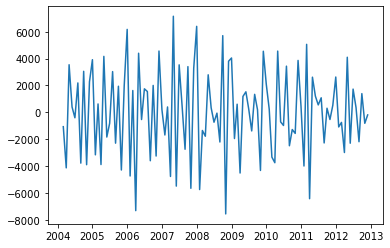

In [7]:
plt.plot(series)

adf 값 p-value가 0.05 작기 때문에 정규성을 띈다고 볼 수 있다. - > adfuller 라이브러릴 사용

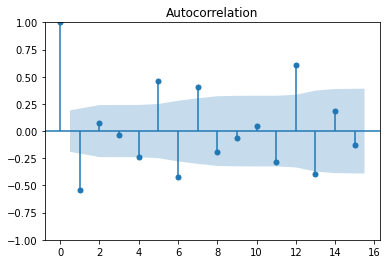

In [8]:
plot_acf(series, lags = 15)
plt.show()

파란색 범위 안에 들어가면 상관관계가 약하다고 할 수 있고, 밖으로 벗어날 수록 상관관계가 크다

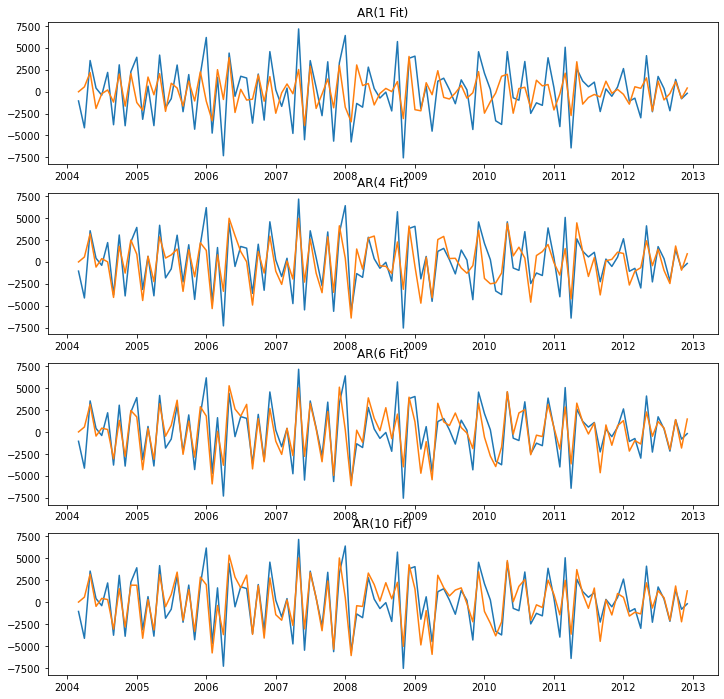

In [9]:
plt.figure(figsize=(12,12))
ar_orders = [1,4,6,10]
fitted_model_dict = {}
for idx, ar_order in enumerate(ar_orders):
    # create AR(p) 모델
    ar_model = ARIMA(series, order=(ar_order,0,0))
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_model] = ar_model_fit
    plt.subplot(4,1,idx+1)
    plt.plot(series)
    plt.plot(ar_model_fit.fittedvalues)
    plt.title(f'AR({ar_order} Fit)')

enumerate 하면 하나씩 인덱스로 넣어줌 !

In [10]:
for ar_order in ar_orders:
    print(f'AIC for ar({ar_order}) : [fitted_model_dict[ar_order].aic]')

AIC for ar(1) : [fitted_model_dict[ar_order].aic]
AIC for ar(4) : [fitted_model_dict[ar_order].aic]
AIC for ar(6) : [fitted_model_dict[ar_order].aic]
AIC for ar(10) : [fitted_model_dict[ar_order].aic]


AIC 값 이 가장 작기 때문에 6으로 판단했다.

BIC도 동일하게 그려보면 된다...피쳐의 개수로 영향을 받는 것! 
- ARIMA 모델에서는 p를 선택하는 방법이 중요하기 때문에 AIC, BIC 값을 사용한다.
- pacf의 절단값에 가까운 것을 선택하거나 AIC 값이 가장 작은 걸 택하는 방식으로 사용

---

# 네이버주식예측(ARIMA)

In [17]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib as plt
import numpy as np

# !pip install pmdarima # numpy업데이트 필요
from pmdarima.arima import ndiffs, auto_arima
import pmdarima as pm

In [5]:
# NAVER의 Symbol 확인
stocklist_df = fdr.StockListing("KRX")

ticker =stocklist_df[stocklist_df["Name"] == "NAVER"]
ticker

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
1338,035420,KOSPI,NAVER,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업",포털 서비스 및 온라인 광고,2008-11-28,12월,최수연,http://www.navercorp.com,경기도


In [6]:
# Naver 주가정보 가져오기 2020년부터
ns = fdr.DataReader('035420', "2020")
ns

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,187500,188000,182000,182500,300640,-0.021448
2020-01-03,185000,186000,180500,181500,454492,-0.005479
2020-01-06,180000,182000,178000,180500,287970,-0.005510
2020-01-07,182500,187000,181500,187000,328624,0.036011
2020-01-08,182000,183500,179000,183000,820867,-0.021390
...,...,...,...,...,...,...
2022-10-13,160500,161000,155000,158500,1487183,-0.021605
2022-10-14,163500,168500,163000,165500,1568930,0.044164
2022-10-17,162500,168000,160500,167000,1436527,0.009063


In [10]:
# len(ns) # 전체 데이터 691개
int(0.7 * len(ns)) # 전체 691개 중 70%인 483을 train data로 사용

483

<AxesSubplot:xlabel='Date'>

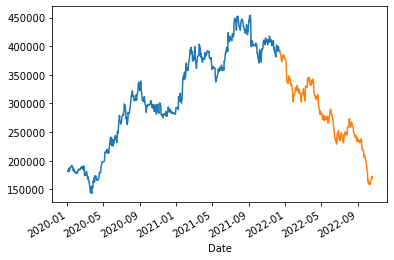

In [11]:
# split train, test set
y_train = ns["Close"] [:int(0.7 * len(ns))] # 0~483
y_test = ns["Close"] [int(0.7 * len(ns)):] # 484 ~ 691
y_train.plot()
y_test.plot()

In [14]:
# 차분 차수 구하기
kpss_dfffs = ndiffs(y_train, alpha=0.05, test="kpss", max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test="adf", max_d=6)

max(kpss_dfffs, adf_diffs) # 큰값 만큼 차분하면 된다. 한 번 차분.

1

In [18]:
# auto_arima : 최적 ARIMA prameter 찾아줌
model = auto_arima(y=y_train, #train data
                    
                    d=1, # d는 차분횟수(위에서구한)
                    start_p=0, max_p=3, # AR(p)
                    start_q=0, max_q=3, # MA(q)
                    
                    m=1,
                    seasonal=False, stepwise=True, trace=True # trace는 파라미터 추적하면서 과정 print!  like grid search
                    )
# ARIMA(p=AR, q=MA, d=차수)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9898.136, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9900.010, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9900.006, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9897.999, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9901.893, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.183 seconds


In [20]:
model.summary()
# ljungbox prob 값, 자크베라 값으로 정규성, stationary 판단.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  483
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4947.999
Date:                Wed, 19 Oct 2022   AIC                           9897.999
Time:                        13:54:36   BIC                           9902.177
Sample:                             0   HQIC                          9899.641
                                - 483                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.821e+07   2.08e+06     23.126      0.000    4.41e+07    5.23e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               119.21
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

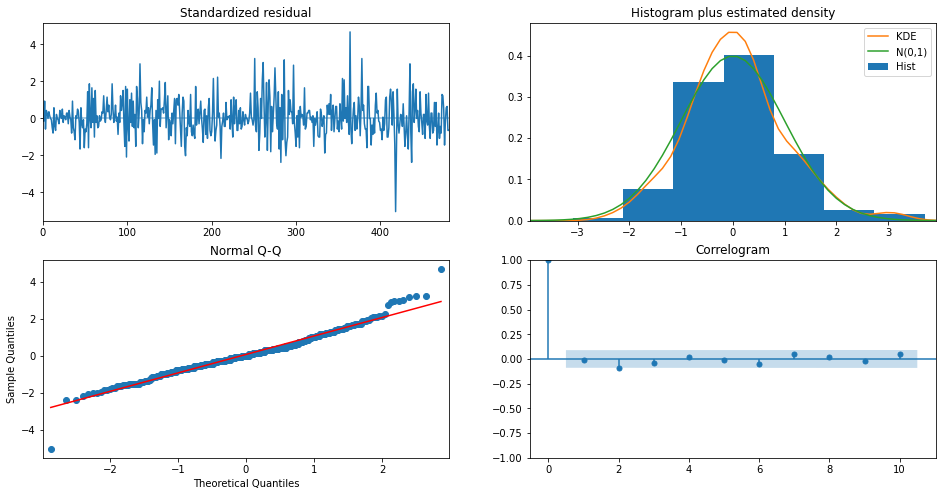

In [31]:
model.plot_diagnostics(figsize=(16,8))
plt.show()


# Correlogram에서 0~1에서 뚝 떨어짐을 볼 수 있다 -> 차분 1번만!

/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


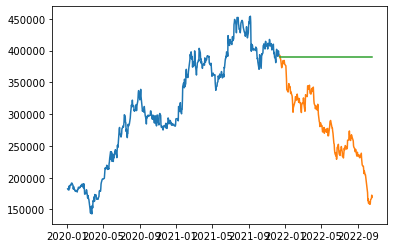

In [59]:
# 만든 Model로 예측하여 Plot으로 예측확인

# y_pred 스리즈를 DF로 만들어서 날짜 인덱스를 추가하지 말고, 스리즈에 인덱스를 바로 넣어주자.
y_pred = model.predict(n_periods=len(y_test))
y_pred.index = pd.Series(y_test.index)
# y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=["Prediction"])

y_train = ns["Close"] [:int(0.7 * len(ns))] # 0~483
y_test = ns["Close"] [int(0.7 * len(ns)):] # 484 ~ 691

plt.plot(y_train, label="Train")
plt.plot(y_test, label="Test")
plt.plot(y_pred, label="Pred")

# y_pred.plot()
# y_train.plot()
# y_test.plot()
plt.show()

In [63]:
def forecast_one_step():
    fc, conf_int = model.predict(n_preiods=1, return_conf_int=True)
    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])
forecast_one_step()

/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


(390500.0, [376890.6946121189, 404109.3053878811])

In [ ]:
forecast = []
y_pred = []
y

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_ipper


In [ ]:
pd.DataFrame 